# 1 Загрузка библиотек

In [169]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
#from matplotlib import style
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
import seaborn as sns 
%matplotlib inline

# импортруем библиотеки ля статистических тестов
from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms
from sklearn import datasets

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# импортируем библиотеку для работы с кодировщиками
import category_encoders as ce

# Модуль для работы с координатами
from geopy.geocoders import Nominatim
from functools import partial

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# 2 Определение функций

In [4]:
# Определем функции
# функция для принятия решения о нормальности данных
def decision_normality(p):
    """Функция определяет нормальность распределения значений

    Args:
        p (p-value): значение-результат статистического теста, с помощью которого определяется нормальность рапсределения значений
    """
    
    print(f"p-value = {p:.3f}")
    if p <= alpha:
        print(f"р-значение меньше, чем заданный уровень значимости {alpha:.2}. Распределение отлично от нормального.")
    else:
        print(f"р-значение больше, чем заданный уровень значимости {alpha:.2}. Распределение является нормальным.")

# функция для принятия решения об отклонении нулевй гипотизы
def decision_gipothesis(p):
    """Функция определяет верность гипотез

    Args:
        p (p-value): значение-результат статистического теста, с помощью которого определяется выбор гипотезы
    """
    
    print(f"p-value = {p:.3f}")
    if p <= alpha:
        print(f"р-значение меньше, чем заданный уровень значимости {alpha:.2}. Отвергаем нулевую гипотезу в пользу альтернативной.")
    else:
        print(f"р-значение больше, чем заданный уровень значимости {alpha:.2}. У нас нет оснований отвергнуть нулевую гипотезу.")
        
        
def get_lower_words (review):
    """Функция преобразовывает текст в строчные буквы и убирает пробелы в начале и конце строк

    Args:
        review (series): str с текстом отзыва
    """
    
    review = review.lower().strip()
    return review


# задаем уровень значимости 5%
alpha = 0.05

# 3 Чтение данных

In [5]:
# Подгрузим наши данные из соревнования

#DATA_DIR = '/kaggle/input/sf-booking/'
#df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
#df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
#sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

hotels = pd.read_csv('data/hotels.csv')

df_train = pd.read_csv('data/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv('data/hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv('data/submission.csv') # самбмишн

## 3.1 Ознакомление с дата-сетами

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [7]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [9]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [11]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [12]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


# 4 Обработка данных

## 4.1 Объединение тренировочного и тестового дата-сетов

In [13]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

C:\Users\dmitr\AppData\Local\Temp/ipykernel_9804/3686891825.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

В дата-фрейме обнаружены пропуски значений в признаках "lat" и "lng"
<br> Также в дата-фрейме содержаться 8 признаков типа "object" и 10 числовых признаков.

In [15]:
data.head(1)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0


## 4.2 Создадим два списка признаков типов "object" и "int"

In [16]:
# проанализируем какие признаки категориальный либо цифровые
obj = []
num = []
for i in data.columns:
    if data[i].dtypes  == 'object':
        obj.append(i)
    else:
        num.append(i)
print(f'Столбцы "object":\n {obj}')
print()
print(f'Столбцы "numeric":\n {num}')

Столбцы "object":
 ['hotel_address', 'review_date', 'hotel_name', 'reviewer_nationality', 'negative_review', 'positive_review', 'tags', 'days_since_review']

Столбцы "numeric":
 ['additional_number_of_scoring', 'average_score', 'review_total_negative_word_counts', 'total_number_of_reviews', 'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given', 'lat', 'lng', 'sample', 'reviewer_score']


Исследуем структуру информации в признаках типа "object"

In [17]:
for i in obj:
    print(i)
    print(f'"{data[i][0]}"\n')

hotel_address
"Via Senigallia 6 20161 Milan Italy"

review_date
"7/21/2017"

hotel_name
"Hotel Da Vinci"

reviewer_nationality
" United Kingdom "

negative_review
" Would have appreciated a shop in the hotel that sold drinking water etc but not necessity Would recommend if like us you arrive late at night to bring drinks from plane airport as there s no shop nearby There is a minibar though if you want to pay those prices "

positive_review
" Hotel was great clean friendly staff free breakfast every morning with good selection good wifi connection nice sized room with bath fridge in room Personally loved the fact that the hotel isn t in the city centre but is literally next to a train station that you can easily get to and from the airport city Would definitely stay again "

tags
"[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 2 nights ']"

days_since_review
"13 days"



В признаках (reviewer_nationality, negative_review, positive_review, tags) присутсвуют пробелы перед и после значений, удалим эти пробелы
В признаке "tags" удалим пробелы после поиска дублей, т.к. после преобразоания данного признака значения становятся списком и функция поиска дубликатов выдает ошибку.

In [18]:
# удаление пробелов
data['reviewer_nationality'] = data['reviewer_nationality'].apply (lambda x: x.strip())
data['negative_review'] = data['negative_review'].apply (lambda x: x.strip())
data['positive_review'] = data['positive_review'].apply (lambda x: x.strip())
#data['tags'] = data['tags'].apply (lambda x: x.replace("[' ", "").replace(" ']", '').split(" ', ' "))

In [19]:
#Проверка на удаление пробелов
for i in obj:
    print(i)
    print(f'"{data[i][0]}"\n')

hotel_address
"Via Senigallia 6 20161 Milan Italy"

review_date
"7/21/2017"

hotel_name
"Hotel Da Vinci"

reviewer_nationality
"United Kingdom"

negative_review
"Would have appreciated a shop in the hotel that sold drinking water etc but not necessity Would recommend if like us you arrive late at night to bring drinks from plane airport as there s no shop nearby There is a minibar though if you want to pay those prices"

positive_review
"Hotel was great clean friendly staff free breakfast every morning with good selection good wifi connection nice sized room with bath fridge in room Personally loved the fact that the hotel isn t in the city centre but is literally next to a train station that you can easily get to and from the airport city Would definitely stay again"

tags
"[' Leisure trip ', ' Couple ', ' Double Room ', ' Stayed 2 nights ']"

days_since_review
"13 days"



Пробелы удалены

## 4.3 Поиск дубликатов в дата-сете

In [20]:
dupl_col = list(data.columns)

mask = data.duplicated(subset=dupl_col)
data_dupl = data[mask]

print(f'Число найденных дубликатов: {data_dupl.shape[0]}')

Число найденных дубликатов: 336


По правилам соревнования удалять строки не можем. Дублирующие записи пометим "1"

In [21]:
data['duplicates'] = mask.apply(lambda x: 1 if x else 0)
print((data['duplicates'].value_counts())[1]) # проверка суммой количество дублирующих строк

336


## 4.4 Поиск пропусков в признаках

In [22]:
#data['lat'] = data['lat'].fillna(0, inplace=True)
#data['lng'] = data['lng'].fillna(0, inplace=True)

<AxesSubplot:>

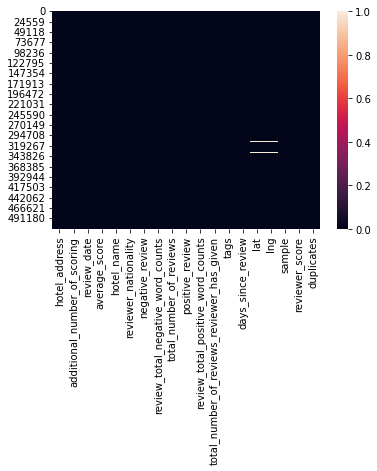

In [23]:
sns.heatmap(data.isnull()) # наглядная карта пропусков

In [24]:
is_null = data.isnull()
row_with_null = is_null.any(axis=1)
row_with_null = data[row_with_null]

In [25]:
data.isnull().sum()

hotel_address                                    0
additional_number_of_scoring                     0
review_date                                      0
average_score                                    0
hotel_name                                       0
reviewer_nationality                             0
negative_review                                  0
review_total_negative_word_counts                0
total_number_of_reviews                          0
positive_review                                  0
review_total_positive_word_counts                0
total_number_of_reviews_reviewer_has_given       0
tags                                             0
days_since_review                                0
lat                                           3268
lng                                           3268
sample                                           0
reviewer_score                                   0
duplicates                                       0
dtype: int64

Обнаружены пропуски в признаках "lat" и "lng"

In [26]:
#Удалим признаки с пропусками "lat" и "lng"
#data = data.drop(['lat', 'lng'], axis=1)
#sns.heatmap(data.isnull())

## 4.5 Преобразование даты "review_date"

In [27]:
# Преобразуем признак в формат datetime
data['review_date'] = pd.to_datetime(data['review_date'])

In [28]:
# проверка 
#data['review_date'].info()

In [29]:
# из признака даты сформируем два отдельных признака год и месяц

# формирование признака "месяц"
data['review_month'] = data['review_date'].dt.month

# формируе признак "год"
data['review_year'] = data['review_date'].dt.year

# удаление признака "review_date"
data.drop('review_date', axis=1, inplace=True)

# проверка
data.info()
# признаки "месяц" и "год" созданы

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 20 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   average_score                               515738 non-null  float64
 3   hotel_name                                  515738 non-null  object 
 4   reviewer_nationality                        515738 non-null  object 
 5   negative_review                             515738 non-null  object 
 6   review_total_negative_word_counts           515738 non-null  int64  
 7   total_number_of_reviews                     515738 non-null  int64  
 8   positive_review                             515738 non-null  object 
 9   review_total_positive_word_counts           515738 non-null  int64  
 

## 4.6 Преобразование адреса отеля "hotel_address"

In [30]:
# анализ структуры записи адреса отеля

print(data['hotel_address'][0])
print(data['hotel_address'][10])
# последнее слово - страна, предпоследнее слово - город

Via Senigallia 6 20161 Milan Italy
Via Giorgio Stephenson 55 20157 Milan Italy


In [31]:
# сформируем два новых признака "country" и "city"
data['country'] = data['hotel_address'].apply(lambda x: x.split(' ')[-1])
data['city'] = data['hotel_address'].apply(lambda x: x.split(' ')[-2])

# проверка
data[['country', 'city']]
# новые признаки сформированы
# некорректно обработалось наименование United Kongdom

,country,city
0,Italy,Milan
1,Netherlands,Amsterdam
2,Spain,Barcelona
3,Italy,Milan
4,Netherlands,Amsterdam
...,...,...
515733,Kingdom,United
515734,Austria,Vienna
515735,Kingdom,United
515736,Kingdom,United


In [32]:
# коррекция признаков "country" и "city"

data['country'] = data['country'].apply(lambda x: 'UK' if x == 'Kingdom' else x)
data['city'] = data['city'].apply(lambda x: 'London' if x == 'United' else x)

# проверка
data[['country', 'city']]

,country,city
0,Italy,Milan
1,Netherlands,Amsterdam
2,Spain,Barcelona
3,Italy,Milan
4,Netherlands,Amsterdam
...,...,...
515733,UK,London
515734,Austria,Vienna
515735,UK,London
515736,UK,London


In [33]:
# удаление признака "hotel_address"
#data.drop('hotel_address', axis=1, inplace=True)

#data.info() 

## 4.7 Кодирование признаков "country" и "city"

In [34]:
# выясним количество уникальных значений стран и городов
display(f'Уникальное количество стран: {data["country"].nunique()}: {data["country"].unique()}')
display(f'Уникальное количество городов: {data["city"].nunique()}: {data["city"].unique()}')

"Уникальное количество стран: 6: ['Italy' 'Netherlands' 'Spain' 'UK' 'France' 'Austria']"

"Уникальное количество городов: 6: ['Milan' 'Amsterdam' 'Barcelona' 'London' 'Paris' 'Vienna']"

In [35]:
# закодируем наименование стран и городов методом однократного кодирования
# dummies метод не подходит, т.к. удаляет кодируемый признак 
#df = data.copy()
#df = pd.get_dummies(df, columns=['country'], drop_first=False)
#df = pd.get_dummies(df, columns=['city'], drop_first=False)

#OneHot кодирование не подходит т.к. создает признаки с неинформативным наименованием
#encoder = ce.OneHotEncoder(cols=['country'])
#type_bin = encoder.fit_transform(data['country'])
#data2 = pd.concat([data, type_bin], axis=1)

In [36]:
# кодируем посредством создания списка наименований будущих признаков и lambda-функции

# создаем список стран
country_list = list(data['country'].unique())

# циклом создаем новые признаки и присваиваем признакам наименование стран строчными буквами
for i in country_list:
    country_col = i.lower()
    # однократное кодирование через lambda-функцию
    data[country_col] = data['country'].apply(lambda x: 1 if i == x else 0)

In [37]:
# создаем список городов
city_list = list(data['city'].unique())

# циклом создаем новые признаки и присваиваем признакам наименование городов строчными буквами
for i in city_list:
    city_col = i.lower()
    # однократное кодирование через lambda-функцию
    data[city_col] = data['city'].apply(lambda x: 1 if i == x else 0)

## 4.8 Добавление дополнительных признаков населения стран и городов

In [38]:
# Добавим три признака:
# население страны,
# население города,
# соотношение населения города к населению страны

# словарь население стран
country_popul = {
    'UK': 665111098,
    'Netherlands': 17032845,
    'France': 64938716,
    'Spain': 46070146,
    'Italy': 59797978,
    'Austria': 8592400
}

data['country_popul'] = data['country'].map(country_popul)


# словарь население городов
сity_popul = {
    'Paris': 2187526,
    'London': 8825000,
    'Milan': 1378000,
    'Vienna': 1888776,
    'Barcelona': 1628936,
    'Amsterdam': 1123000
}

data['сity_popul'] = data['city'].map(сity_popul)

# соотношение населения города к населению страны
data['diff_popul'] = round(data['сity_popul'] / data['country_popul'], 4) # округлим до 4 знаков

In [39]:
data.head(1)

,hotel_address,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,...,austria,milan,amsterdam,barcelona,london,paris,vienna,country_popul,сity_popul,diff_popul
0,Via Senigallia 6 20161 Milan Italy,904,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel tha...,52,16670,Hotel was great clean friendly staff free brea...,62,...,0,1,0,0,0,0,0,59797978,1378000,0.023


## 4.9 Восстановление пропущенных признаков координат городов

In [40]:

# создадим дата-сет с пропущенными координатами
city_geo = data[(data['lat'].isna()) & (data['lng'].isna())]['city']
#print(city_geo.unique())

#создадим список городов с пропущенными координатами
city_geo_str = list(city_geo.unique())
city_geo_str

['Vienna', 'Paris', 'Barcelona']

In [41]:
# восстановление пропущенных координат "lat" и "lng"
geolocator = Nominatim(user_agent='USER_AGENT')

for i in city_geo_str:
    geocode = partial(geolocator.geocode, language="en")
    location = geolocator.geocode(i)
    print(str(geocode(i)).split(',')[0])
    
    # округлим значение координат до 8 символов
    if len(str(location.latitude)) > 8 or len(str(location.longitude)) > 8:
        lat = float(str(location.latitude)[:8])
        lng = float(str(location.longitude)[:8])
    else:
        lat = location.latitude
        lng = location.longitude
    
    # заполнение отсутствующих координат по соответсвующим городам
    data['lat'] = np.where(((data['lat'].isna()) & (data['city'] == i)), lat, data['lat']).astype('float64')
    data['lng'] = np.where(((data['lng'].isna()) & (data['city'] == i)), lng, data['lng']).astype('float64')
    #print(lat, lng)

Vienna
Paris
Barcelona


In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 37 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   average_score                               515738 non-null  float64
 3   hotel_name                                  515738 non-null  object 
 4   reviewer_nationality                        515738 non-null  object 
 5   negative_review                             515738 non-null  object 
 6   review_total_negative_word_counts           515738 non-null  int64  
 7   total_number_of_reviews                     515738 non-null  int64  
 8   positive_review                             515738 non-null  object 
 9   review_total_positive_word_counts           515738 non-null  int64  
 

<AxesSubplot:>

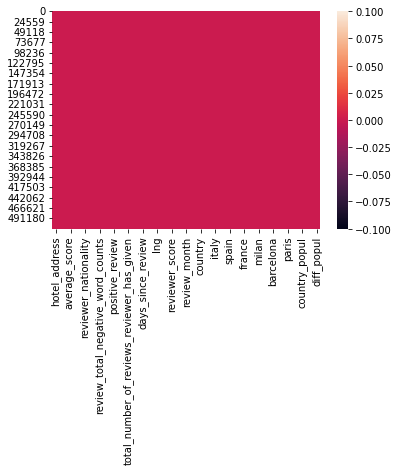

In [43]:
# проверка дата-сета на наличие пропусков
sns.heatmap(data.isnull())

# пропусков не обнаружено

## 4.10 Анализ национальности (гражданства) посетителей отелей

In [44]:
# Произведем подсчет уникальных значений национальностей посетителей
print(f'Количество уникальных значений национальностей посетителей отелей: {data["reviewer_nationality"].nunique()}')

Количество уникальных значений национальностей посетителей отелей: 227


In [45]:
# отбирем 15 самых часто встречаемых значений национальности, остальным присвоим значение other и закодируем
data['reviewer_nationality'].value_counts().head(20)

United Kingdom              245246
United States of America     35437
Australia                    21686
Ireland                      14827
United Arab Emirates         10235
Saudi Arabia                  8951
Netherlands                   8772
Switzerland                   8678
Germany                       7941
Canada                        7894
France                        7296
Israel                        6610
Italy                         6114
Belgium                       6031
Turkey                        5444
Kuwait                        4920
Spain                         4737
Romania                       4552
Russia                        3900
South Africa                  3821
Name: reviewer_nationality, dtype: int64

In [46]:
# изменим значение национальность - United Kingdom на UK, чтобы в дальшейшем корректно отобразить внутрених туристов UK == UK
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: 'UK' if x == 'United Kingdom' else x)

In [47]:
# создадим дата-сет с 15 часто встречаемых значений
national_15 = data['reviewer_nationality'].value_counts().nlargest(15).index

# заменим другие национальности значением other
data['reviewer_nationality'] = data['reviewer_nationality'].apply(lambda x: x if x in national_15 else 'Other')

In [48]:
# чтобы не создавать 15 новых колонок применим бинарное кодирование к признаку "reviewer_nationality"
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality'])
type_bin = bin_encoder.fit_transform(data['reviewer_nationality'])
data = pd.concat([data, type_bin], axis=1)

In [49]:
# создадим признак для посетителей отелей внутри своей страны
data['local_reviewer'] = data['reviewer_nationality'] == data['country']
#data['local_reviewer'].value_counts()

# преобразуем признак local_reviewer из bool в int8
data = data.astype({'local_reviewer':np.int8})

In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 43 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   average_score                               515738 non-null  float64
 3   hotel_name                                  515738 non-null  object 
 4   reviewer_nationality                        515738 non-null  object 
 5   negative_review                             515738 non-null  object 
 6   review_total_negative_word_counts           515738 non-null  int64  
 7   total_number_of_reviews                     515738 non-null  int64  
 8   positive_review                             515738 non-null  object 
 9   review_total_positive_word_counts           515738 non-null  int64  
 

## 4.11 Анализ отзывов об отелях

In [51]:
# исследуем в дата-сете информацию об отзывах
'''display(data[['negative_review',
            'review_total_negative_word_counts',
            'total_number_of_reviews',
            'positive_review',
            'review_total_positive_word_counts',
            'total_number_of_reviews_reviewer_has_given']])'''
            

all_review = data[['negative_review',
            'review_total_negative_word_counts',
            'total_number_of_reviews',
            'positive_review',
            'review_total_positive_word_counts',
            'total_number_of_reviews_reviewer_has_given']]
all_review.head()
# первичный анализ показывает, к примеру, в строке три количество слов не соответствует указанному значению
# в строке  2 отзыв по смылслу не позитивный, но указан в столбце позитивных отзывов, т.е. необходимо также проверить отзывы по смыслу
# посетители указывают, что конкретно им нравится или не нравится, к примеру, комната, персонал, сервис и т.д.

,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given
0,Would have appreciated a shop in the hotel tha...,52,16670,Hotel was great clean friendly staff free brea...,62,1
1,No tissue paper box was present at the room,10,5018,No Positive,0,7
2,Pillows,3,351,Nice welcoming and service,5,15
3,No Negative,0,1543,Everything including the nice upgrade The Hote...,27,9
4,No Negative,0,4687,Lovely hotel v welcoming staff,7,2


In [52]:
# проверка предположения, что указано ошибочное количество слов отзыва.
# в предыдущем запросе указано значение 52, в действительности 50
len((data['negative_review'][0].split()))

50

In [53]:
# произведем коррекцию значений в столбцах по уоличеству слов в отзывах
#df = data.copy()
data['review_total_negative_word_counts'] = data['negative_review'].apply(lambda x: len(x.split()))
data['review_total_positive_word_counts'] = data['positive_review'].apply(lambda x: len(x.split()))

In [54]:
# проверка
data[['negative_review',
            'review_total_negative_word_counts',
            'total_number_of_reviews',
            'positive_review',
            'review_total_positive_word_counts',
            'total_number_of_reviews_reviewer_has_given']].head()

# данные откорректированы

,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given
0,Would have appreciated a shop in the hotel tha...,50,16670,Hotel was great clean friendly staff free brea...,60,1
1,No tissue paper box was present at the room,9,5018,No Positive,2,7
2,Pillows,1,351,Nice welcoming and service,4,15
3,No Negative,2,1543,Everything including the nice upgrade The Hote...,26,9
4,No Negative,2,4687,Lovely hotel v welcoming staff,5,2


In [55]:
# преобразуем текст отзывов в строчные буквы
data['negative_review'] = data['negative_review'].apply(get_lower_words)
data['positive_review'] = data['positive_review'].apply(get_lower_words)


In [56]:
# откорректируем смысл отзывов, т.е. в найдем положительные отзывы в негативных и наоборот

# анализируем самые частые формулировки
data['negative_review'].value_counts().head(30)
# наблюдаем большое количество отзывов с НЕ отрицательным смыслом
# наблюдаем негативные отзывы в отношении комнаты, цены, локации, еды,персонала и т.д. - далее закодируем данные признаки


no negative                  127890
nothing                       21185
n a                            1815
none                           1501
                                849
nothing really                  656
small room                      570
all good                        545
breakfast                       545
no complaints                   523
location                        502
nothing at all                  467
everything                      420
nothing to dislike              373
price                           348
nil                             332
small rooms                     307
everything was perfect          276
na                              272
can t think of anything         250
leaving                         244
absolutely nothing              242
everything was great            222
expensive                       206
nothing to complain about       205
no                              200
very small room                 200
room size                   

In [57]:
# создадим список НЕ негативных выражений

not_negative_review = ['no negative', 'nothing', 'n a', 'none', '', 'no', 'no complaints', 'nil', 'nothing really',
                       'all good', 'na', 'nothing at all', 'everything was perfect', 'can t think of anything',
                       'absolutely nothing','everything was perfect', 'nothing to dislike',
                       'nothing to complain about', 'everything was great', 'nothing not to like',
                       'liked everything', 'everything was great', 'absolutely nothing','everything was good',
                       'all was good', 'i liked everything', 'nothing to complain about', 'no thing',
                       'nothing not to like', 'nothing everything was perfect', 'nothing everything was great',
                       'all ok', 'nothing it was perfec', 'i liked everything', 'nothing it was perfect',
                       'everything was good', 'nothing i didn t like', 'everything was fine',
                       'nothing everything was perfect', 'there was nothing i didn t like', 'nothing comes to mind',
                       'no dislikes', 'no comment', 'no negatives', 'not a thing', 'nothing to mention',
                       'nothing comes to mind', 'nothing to report', 'no complaints at all']

In [58]:
# создадим временный признак-"копия негативных отзывов" для отделения истинно негативных от НЕ негативных
data['negative_review_copy'] = data['negative_review'].apply(lambda x: '1' if x in not_negative_review else x)

In [59]:
# анализ причин жалоб посетителей
data['negative_review_copy'].value_counts().head(20)

1                      160082
small room                570
breakfast                 545
location                  502
everything                420
price                     348
small rooms               307
leaving                   244
expensive                 206
room size                 200
very small room           200
nothing all good          181
staff                     181
having to leave           176
not much                  159
see above                 141
expensive breakfast       138
non                       134
the price                 132
room too small            127
Name: negative_review_copy, dtype: int64

In [60]:
# в рамках данного исследования выберим несколько пунктов: комната, душевая, локация, персонал, цена, питание

# жалобы на номер
data['neg_room'] = data['negative_review_copy'].apply(lambda x: 1 if ('room' in x) or ('bed' in x) or ('beds' in x) or ('old' in x) else 0) 
display(data['neg_room'].value_counts())

# жалобы на локацию
data['neg_location'] = data['negative_review_copy'].apply(lambda x: 1 if ('location' in x) or ('place' in x) else 0) 
display(data['neg_location'].value_counts())

# жалобы на персонал и уборку
data['neg_staff'] = data['negative_review_copy'].apply(lambda x: 1 if ('staff' in x)
                                                      or ('cleaning' in x) or ('clean' in x) or ('dirt' in x) else 0) 
display(data['neg_staff'].value_counts())

# жалобы на питание
data['neg_eat'] = data['negative_review_copy'].apply(lambda x: 1 if ('breakfast' in x) or ('eat' in x)
                                                    or ('dinner' in x) or ('lunch' in x) or ('meal' in x) else 0)
display(data['neg_eat'].value_counts())
        
# жалобы на стоимость
data['neg_price'] = data['negative_review_copy'].apply(lambda x: 1 if ('price' in x) or ('expensive' in x) or ('cost' in x) else 0)
display(data['neg_price'].value_counts())


# жалобы на интернет
data['neg_wifi'] = data['negative_review_copy'].apply(lambda x: 1 if ('wi-fi' in x) or ('internet' in x)
                                                      or ('wi fi' in x) or ('wifi' in x) else 0) 
display(data['neg_wifi'].value_counts()) # проверяем работу lambda-функции


# жалобы на ванную и душевую
data['neg_bath'] = data['negative_review_copy'].apply(lambda x: 1 if ('bath' in x) or ('toilet' in x) else 0) 
display(data['neg_bath'].value_counts())

# жалобы "всё плохо"
data['neg_all'] = data['negative_review_copy'].apply(lambda x: 1 if ('all' in x) or ('everything' in x) else 0) 
display(data['neg_all'].value_counts())

# данное распределение может помочь понять на что именно жалуются посетители и принять соответствующие решения со стороны руководства отелей


0    334690
1    181048
Name: neg_room, dtype: int64

0    495680
1     20058
Name: neg_location, dtype: int64

0    462876
1     52862
Name: neg_staff, dtype: int64

0    443824
1     71914
Name: neg_eat, dtype: int64

0    475452
1     40286
Name: neg_price, dtype: int64

0    498662
1     17076
Name: neg_wifi, dtype: int64

0    477926
1     37812
Name: neg_bath, dtype: int64

0    406208
1    109530
Name: neg_all, dtype: int64

In [61]:
# создадим список НЕ позитивных выражений

not_positive_review = ['no positive', 'nothing', 'n a', 'none', 'no', 'no complaints', ' ', '']

# создадим временный признак-"копия позитивных отзывов" для отделения истинно позитивных от НЕ позитивных
data['positive_review_copy'] = data['positive_review'].apply(lambda x: '1' if x in not_positive_review else x)

In [62]:
# анализ причин причин положительных отзывов посетителей
data['positive_review_copy'].value_counts().head(20)

1                             38004
location                      11945
everything                     3314
great location                 1687
the location                   1606
good location                  1496
breakfast                       795
friendly staff                  733
excellent location              639
staff                           553
location and staff              452
location staff                  432
location location location      345
location was great              328
good breakfast                  316
everything was perfect          316
location was good               312
comfy bed                       303
perfect location                287
the staff                       281
Name: positive_review_copy, dtype: int64

In [63]:
# в рамках данного исследования выберим несколько пунктов: комната, душевая, локация, персонал, цена, питание

# понравился номер
data['pos_room'] = data['positive_review_copy'].apply(lambda x: 1 if ('room' in x) or ('bed' in x) or ('beds' in x) or ('old' in x) else 0) 
display(data['pos_room'].value_counts())

# # понравилась локация
data['pos_location'] = data['positive_review_copy'].apply(lambda x: 1 if ('location' in x) or ('place' in x) else 0) 
display(data['pos_location'].value_counts())

# понравился персонал и уборка
data['pos_staff'] = data['positive_review_copy'].apply(lambda x: 1 if ('staff' in x)
                                                      or ('cleaning' in x) or ('clean' in x) or ('dirt' in x) else 0) 
display(data['pos_staff'].value_counts())

# понравилось питание
data['pos_eat'] = data['positive_review_copy'].apply(lambda x: 1 if ('breakfast' in x) or ('eat' in x)
                                                    or ('dinner' in x) or ('lunch' in x) or ('meal' in x) else 0)
display(data['pos_eat'].value_counts())
        
# понравилась стоимость
data['pos_price'] = data['positive_review_copy'].apply(lambda x: 1 if ('price' in x) or ('expensive' in x) or ('cost' in x) else 0)
display(data['pos_price'].value_counts())


# понравился интернет
data['pos_wifi'] = data['positive_review_copy'].apply(lambda x: 1 if ('wi-fi' in x) or ('internet' in x)
                                                      or ('wi fi' in x) or ('wifi' in x) else 0) 
display(data['pos_wifi'].value_counts()) # проверяем работу lambda-функции


# понравились ванная/душевая и туалет
data['pos_bath'] = data['positive_review_copy'].apply(lambda x: 1 if ('bath' in x) or ('toilet' in x) else 0) 
display(data['pos_bath'].value_counts())

# "всё понравилось"
data['pos_all'] = data['positive_review_copy'].apply(lambda x: 1 if ('all' in x) or ('everything' in x) else 0) 
display(data['pos_all'].value_counts())

# данное распределение может помочь понять, что именно понравилось посетителям и рекламировать эти конкурентные преимущества

0    319788
1    195950
Name: pos_room, dtype: int64

0    316826
1    198912
Name: pos_location, dtype: int64

0    288268
1    227470
Name: pos_staff, dtype: int64

0    352819
1    162919
Name: pos_eat, dtype: int64

0    500889
1     14849
Name: pos_price, dtype: int64

0    505687
1     10051
Name: pos_wifi, dtype: int64

0    491583
1     24155
Name: pos_bath, dtype: int64

0    412517
1    103221
Name: pos_all, dtype: int64

In [64]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 61 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   average_score                               515738 non-null  float64
 3   hotel_name                                  515738 non-null  object 
 4   reviewer_nationality                        515738 non-null  object 
 5   negative_review                             515738 non-null  object 
 6   review_total_negative_word_counts           515738 non-null  int64  
 7   total_number_of_reviews                     515738 non-null  int64  
 8   positive_review                             515738 non-null  object 
 9   review_total_positive_word_counts           515738 non-null  int64  
 

## 4.12 Анализ тегов

In [65]:
def tags (tg_data):
    tg_data = tg_data[2:-2]
    tg_data = tg_data.replace("[' ", "").replace(" ']", '').replace("'", "")#.replace(" ", "")
    tg_data = tg_data.split(", ")
    #tagses = pd.DataFrame(tg__data)
    return tg_data

In [66]:
df = data[['tags']].copy()
df.info()

df['lst_tags'] = df['tags'].apply(tags)
df_tg = df.explode('lst_tags')
df_tg['lst_tags'][0]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   tags    515738 non-null  object
dtypes: object(1)
memory usage: 3.9+ MB


0        Leisure trip 
0              Couple 
0         Double Room 
0     Stayed 2 nights 
Name: lst_tags, dtype: object

In [67]:
df_tg['lst_tags'].value_counts().head(25)

 Leisure trip                       417778
 Submitted from a mobile device     307640
 Couple                             252294
 Stayed 1 night                     193645
 Stayed 2 nights                    133937
 Solo traveler                      108545
 Stayed 3 nights                     95821
 Business trip                       82939
 Group                               65392
 Family with young children          61015
 Stayed 4 nights                     47817
 Double Room                         35207
 Standard Double Room                32248
 Superior Double Room                31393
 Family with older children          26349
 Deluxe Double Room                  24823
 Double or Twin Room                 22393
 Stayed 5 nights                     20845
 Standard Double or Twin Room        17483
 Classic Double Room                 16989
 Superior Double or Twin Room        13570
 2 rooms                             12393
 Stayed 6 nights                      9776
 Standard T

In [68]:
# в рамках данного исследования экспертным путем выделим 10 основных тегов и закодируем их

# путешествие - отдых
data['leisure_trip'] = data['tags'].apply(lambda x: 1 if 'Leisure trip' in x else 0)

# отдых на две персоны
data['couple'] = data['tags'].apply(lambda x: 1 if 'Couple' in x else 0)

# отдых одной персоны
data['solo_traveler'] = data['tags'].apply(lambda x: 1 if 'Solo traveler' in x else 0)

# Бизнес-поездка
data['business_trip'] = data['tags'].apply(lambda x: 1 if 'Business trip' in x else 0)

# Отдых компанией
data['group'] = data['tags'].apply(lambda x: 1 if 'Group' in x else 0)

# Семейный отдых с меленькими детьми
data['family_young_children'] = data['tags'].apply(lambda x: 1 if 'Family with young children' in x else 0)

# Семейный отдых с детьми подростками
data['family_older_children'] = data['tags'].apply(lambda x: 1 if 'Family with older children' in x else 0)

# Одноместные номера
data['single_rooms'] = data['tags'].apply(lambda x: 1 if 'Single' in x else 0)

# Двухместные номера
data['double_rooms'] = data['tags'].apply(lambda x: 1 if 'Double' in x else 0)

# Стандартные номера
data['standart_rooms'] = data['tags'].apply(lambda x: 1 if 'Standard' in x else 0)

# Классические номера
data['classic_rooms'] = data['tags'].apply(lambda x: 1 if 'Classic' in x else 0)

# Супер номера
data['super_rooms'] = data['tags'].apply(lambda x: 1 if 'Superior' in x else 0)

# Роскошные номера
data['luxury_rooms'] = data['tags'].apply(lambda x: 1 if 'Luxury' in x else 0)

In [69]:
# из тегов определим на какое количество ночей приезжали посетители

data['number_nights'] = data['tags'].str.extract(r'Stayed (\d+) night').fillna(1).astype(int)
# в 192 случаях количество ночей не указано, поэтому заменим пропуски модой, т.е. 1.
# Т.к. в отель заселяются минимум на одну ночь

# 5. Визуализация и статистическое исследование

## 5.1 Визуальный анализ (графики)

<AxesSubplot:title={'center':'Количество негативных отзывов по категориям'}>

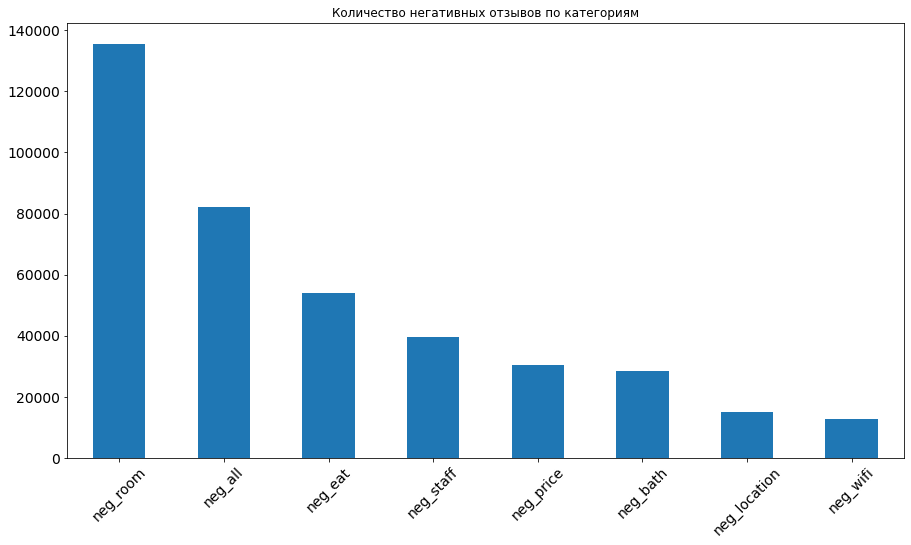

In [70]:
# визуализируем отрицателные отзывы по категориям
data_neg = data[data['sample'] == 1] # визуализируем данные с тренировочного дата-сета

x_neg = data_neg.loc[:, 'neg_room':'neg_all']
d_neg = x_neg.sum()
d_neg.sort_values(ascending=False, inplace=True)
d_neg.plot(kind='bar',
       figsize=(15, 8),
       fontsize = 14,
       rot=45,
       title='Количество негативных отзывов по категориям')

# график показывает каких жалоб больше и позволяет определить приоритетные направления развития отелей
# руководству отеля необходимо братить внимание на качество номеров, еды и работу персонала в первую очередь
# анализ возможно проводить по странам и городам в отдельности
# отзыв "neg_all" можно не учитывать, т.к. он не содержит конкретики

<AxesSubplot:title={'center':'Количество положительных отзывов по категориям'}>

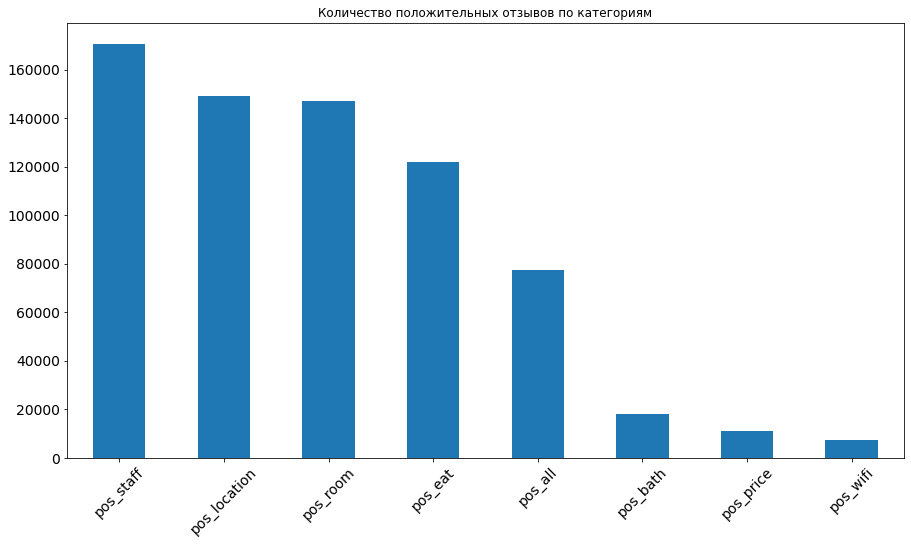

In [71]:
# визуализируем положительных отзывы по категориям

data_pos = data[data['sample'] == 1] # визуализируем данные с тренировочного дата-сета

x_pos = data_pos.loc[:, 'pos_room':'pos_all']
d_pos = x_pos.sum()
d_pos.sort_values(ascending=False, inplace=True)
d_pos.plot(kind='bar',
       figsize=(15, 8),
       fontsize = 14,
       rot=45,
       title='Количество положительных отзывов по категориям')

# график показывает, что больше всего понравилось посетителям
# в рекламе отеля можно использовать его сильные стороны: доброжелательный персонал, удобная локация, комфорт номеров, вкусная еда
# отзыв "pos_all" можно не учитывать, т.к. он не содержит конкретики

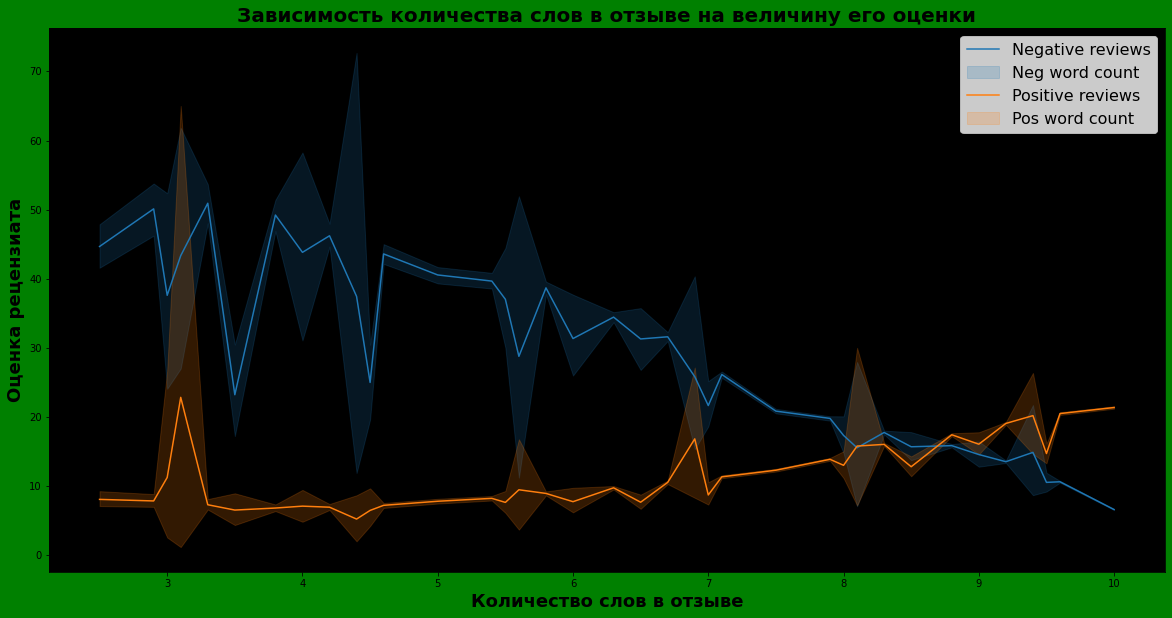

In [72]:
# Проведем визуальный анализ зависимости количество слов в отзыве на его оценку
df = data[data['sample'] == 1] # визуализируем данные с тренировочного дата-сета

#plt.style.use('dark_background')
fig, axes = plt.subplots(figsize=(20, 10), facecolor='green')

sns.lineplot(data = df, x = "reviewer_score", y = "review_total_negative_word_counts", ax=axes) # синий негатив

sns.lineplot(data = df, x = "reviewer_score", y = "review_total_positive_word_counts", ax=axes) # красный позитив

axes.set_title('Зависимость количества слов в отзыве на величину его оценки', fontsize=20, fontweight='bold')
axes.set_xlabel('Количество слов в отзыве', fontsize=18, fontweight='bold')
axes.set_ylabel('Оценка рецензиата', fontsize=18, fontweight='bold')
axes.legend(['Negative reviews', 'Neg word count', 'Positive reviews', 'Pos word count'], loc='upper right', fontsize=16)
axes.set_facecolor('black') # пробы применения фоновых цветов

plt.show() 

Данный график показывает две прямые зависимости:
1. чем больше количество слов в негативном отзыве, тем меньше оценка
2. чем больше количество слов в положительном отзыве, тем больше оценка

С помощью получившегося дата-сета можно построить множество графиков и искать закономерности, к примеру, в какой стране отели получили большую среднюю оценку, внутренний или внешний турист ставит больше баллов, в какие месяца или годы было больше оценок и т.д.

## 5.2. Гепотизы и стаистические тесты

### Руководство отелей должно заботиться о повышении уровня обслуживания клиентов, чтобы увеличивать свою среднюю оценку и соотвественно увеличивать привлекательность для потенциальных посетителей

### Определим наблюдается ли ежегодный рост средной оценки отелей, на основе общего количества оценок рецензиатов (reviewer_score) с помощью статистического теста.

In [151]:
# используем данные с тренировочного дата-сета
df_rev_year = data.loc[(data['sample'] == 1), ['review_year', 'reviewer_score']] # формируем новый дата-сет: оценка и год оценки

df_rev_year['review_year'].value_counts()

#присутствуют данные за три года и в разном количестве

2016    198215
2017    117639
2015     70949
Name: review_year, dtype: int64

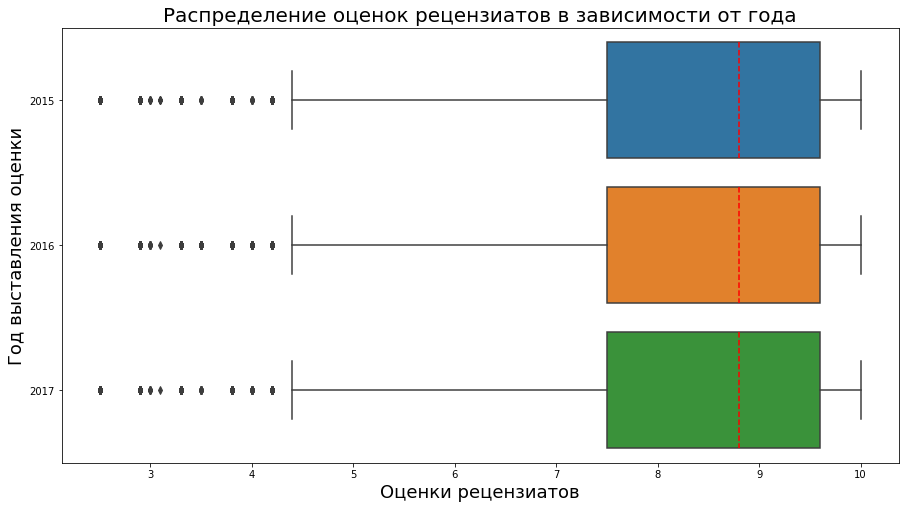

In [152]:
# Строим коробчатые диаграммы распределения оценок в зависимости от года
plt.figure(figsize=(15, 8))
ax = sns.boxplot(data=df_rev_year, x="reviewer_score", y="review_year", orient='h', medianprops={"color": "red", "linestyle": '--'})
ax.set_xlabel('Оценки рецензиатов', fontsize=18)
ax.set_ylabel('Год выставления оценки', fontsize=18)
plt.title('Распределение оценок рецензиатов в зависимости от года', fontsize=20)
plt.show()

# Анализ коробатой диагарммы показывает, что средняя на основе оценок рецензиатов по годам не изменяется
# Поялвяется предположение, что на данных 2015 года можно предполагать какие оценки будут в 2017 году и позже.


### Сформулируем гипотезы<br>
*Нулевая гипотеза* ($H_0$): ежегодный рост средней оценки отелей на основе оценок рецензиатов не наблюдается.
$$ H_1 : μ_1 = μ_2 $$

<br>*Альтернативная гипотеза* ($H_1$): наблюдается ежегодный рост средней оценки отелей на основе оценок рецензиатов.
$$ H_1 : μ_1 \neq μ_2 $$

**Проверка на нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально. Гипотезы теста Шапиро-Уилка:

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [192]:
df_rev_year_2015 = df_rev_year.loc[df_rev_year['review_year']==2015]
df_rev_year_2016 = df_rev_year.loc[df_rev_year['review_year']==2016]
df_rev_year_2017 = df_rev_year.loc[df_rev_year['review_year']==2017]



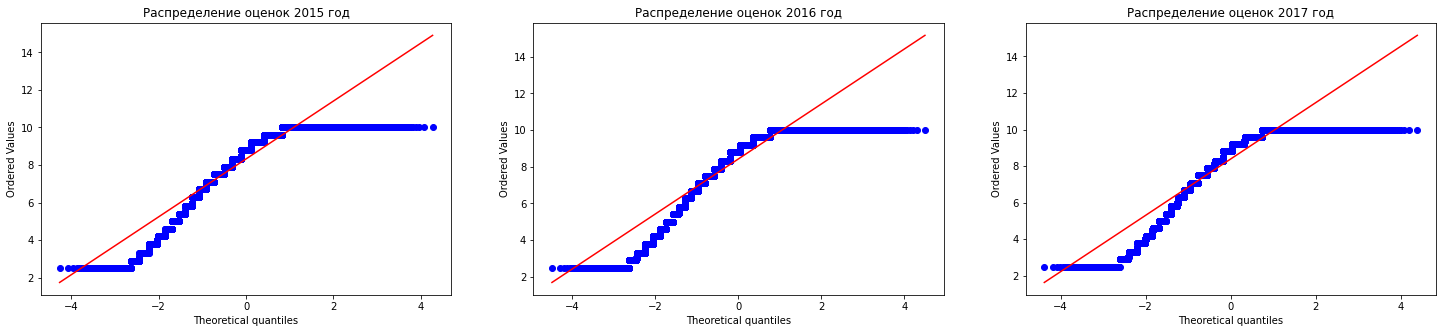

In [194]:
fig, axes = plt.subplots(1, 3, figsize=(25, 5))

stats.probplot(df_rev_year_2015['reviewer_score'], plot=axes[0])
axes[0].set_title('Распределение оценок 2015 год')

stats.probplot(df_rev_year_2016['reviewer_score'], plot=axes[1])
axes[1].set_title('Распределение оценок 2016 год')

stats.probplot(df_rev_year_2017['reviewer_score'], plot=axes[2])
axes[2].set_title('Распределение оценок 2017 год')

plt.show()

In [196]:
df_rev_year_2016.head()

,review_year,reviewer_score
128935,2016,10.0
128937,2016,7.5
128939,2016,9.6
128944,2016,6.7
128945,2016,7.9


# Бэкап

In [73]:
data_bkup = data.copy()
#data_bkup.info()
#data = data_bkup.copy()

In [74]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 75 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   average_score                               515738 non-null  float64
 3   hotel_name                                  515738 non-null  object 
 4   reviewer_nationality                        515738 non-null  object 
 5   negative_review                             515738 non-null  object 
 6   review_total_negative_word_counts           515738 non-null  int64  
 7   total_number_of_reviews                     515738 non-null  int64  
 8   positive_review                             515738 non-null  object 
 9   review_total_positive_word_counts           515738 non-null  int64  
 

# Разрез

In [ ]:
# визуализируем положительных отзывы по категориям
x = data.loc[:, 'pos_room':'pos_all']
d = x.sum()
d.sort_values(ascending=False, inplace=True)
d.plot(kind='bar',
       figsize=(15, 8),
       fontsize = 14,
       rot=45,
       title='Количество положительных отзывов по категориям')

In [ ]:
display(data.iloc[:1, :7])

In [ ]:
data.nunique(dropna=False)

In [ ]:
data['review_year'].unique()

In [ ]:
plt.rcParams['figure.figsize'] = (25, 25)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)

In [ ]:
# убираем признаки которые еще не успели обработать, 
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)

In [ ]:
#Уменьшаем объем памяти выделенную под дата-сет, где возможно int64 преобразуем в int8
data2 = data.copy()
data2 = data2.astype({'italy':np.int8, 'netherlands':np.int8, 'spain':np.int8, 'uk':np.int8, 'france':np.int8, 'austria':np.int8})
data2 = data2.astype({'milan':np.int8, 'amsterdam':np.int8, 'barcelona':np.int8, 'london':np.int8, 'paris':np.int8, 'vienna':np.int8})
data2 = data2.astype({'reviewer_nationality_0':np.int8, 'reviewer_nationality_1':np.int8, 'reviewer_nationality_2':np.int8, 'reviewer_nationality_3':np.int8, 'reviewer_nationality_4':np.int8})


In [ ]:
data.info()

In [ ]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [ ]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [ ]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

In [ ]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [ ]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [ ]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

In [ ]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_error(y_test, y_pred))

In [ ]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [ ]:
test_data.sample(10)

In [ ]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [ ]:
sample_submission

In [ ]:
predict_submission = model.predict(test_data)

In [ ]:
predict_submission

In [ ]:
list(sample_submission)

In [ ]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission2.csv', index=False)
sample_submission.head(10)